# Project: Identify Customer Segments

In this project, apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data for this notebook is provided by a Udacity's partner. For the data security reason, I will not share detailed data here but just demonstrate the analysis procedure.

In [2]:
# import libraries here;
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project, note that as I mentioned below, for the data security reason, I will not share the dataset but just the analysis result:

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. 

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.describe()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
customers.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [7]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]




## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. I parsed it to identify and clean the data. To be specific, I converted data that matches a 'missing' or 'unknown' value code into a numpy NaN value. 

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
for n, feat in enumerate(feat_info['attribute']):
    values = feat_info.loc[n, 'missing_or_unknown']
    values_list = []
    try:
        values_list = [int(x) for x in values[1:-1].split(',')]
        for value in values_list:
            customers.loc[customers[feat] == value, feat] = np.nan
            azdias.loc[azdias[feat]==value, feat] = np.nan
    except:
        pass
    
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. I visualize the distribution of missing value counts to find these columns. I dropped these outlier columns for later use.

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

feat_null = azdias.isnull().sum(axis = 0)
print(feat_null)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

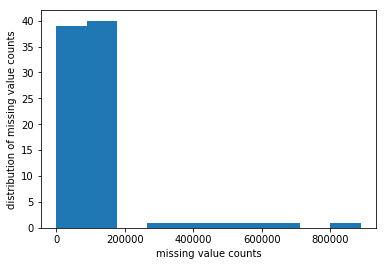

In [10]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(feat_null)
plt.xlabel('missing value counts')
plt.ylabel('distribution of missing value counts')
plt.show()


In [11]:
# Remove the outlier columns from the dataset.
feats_out = []
for n, feat in enumerate(feat_info['attribute']):
    counts = len(azdias) - azdias[feat].count()
    if counts > 200000:
#         azdias.drop(feat, axis = 1)
        feats_out.append(feat)
print(feats_out)
azdias.drop(feats_out, axis = 1, inplace = True)
azdias.head(5)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column


For most features, the amount of missing data is below 200, 000, however, there are 6 features having the amount of missing values greater than 200, 000, including ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], which I regard as outliers and were removed from the dataset. For the amount of missing values, I discovered that some features which share the same prefix such as PLZ8 share the same amount of missing values (e.g. PLZ8_X features are all having 116515 missing values). I assume these features are closely related to each other as they were very likely observed the same time. 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. I selected five of these columns and compare the distribution of values.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special.

In [12]:
# How much data is missing in each row of the dataset?
row_null = azdias.isnull().sum(axis = 1)
print(row_null)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64


In [13]:
# divide the data into two subsets based on the number of missing
# values in each row.

rows_gt_20 = []
rows_lt_20 = []
for ind, value in enumerate(row_null):
    if value >20:
        rows_gt_20.append(ind)
    else:
        rows_lt_20.append(ind)
azdias_gt_20 = azdias.copy()
azdias_gt_20.drop(rows_lt_20, axis = 0, inplace = True)
azdias_lt_20 = azdias.copy()
azdias_lt_20.drop(rows_gt_20, axis = 0, inplace = True)


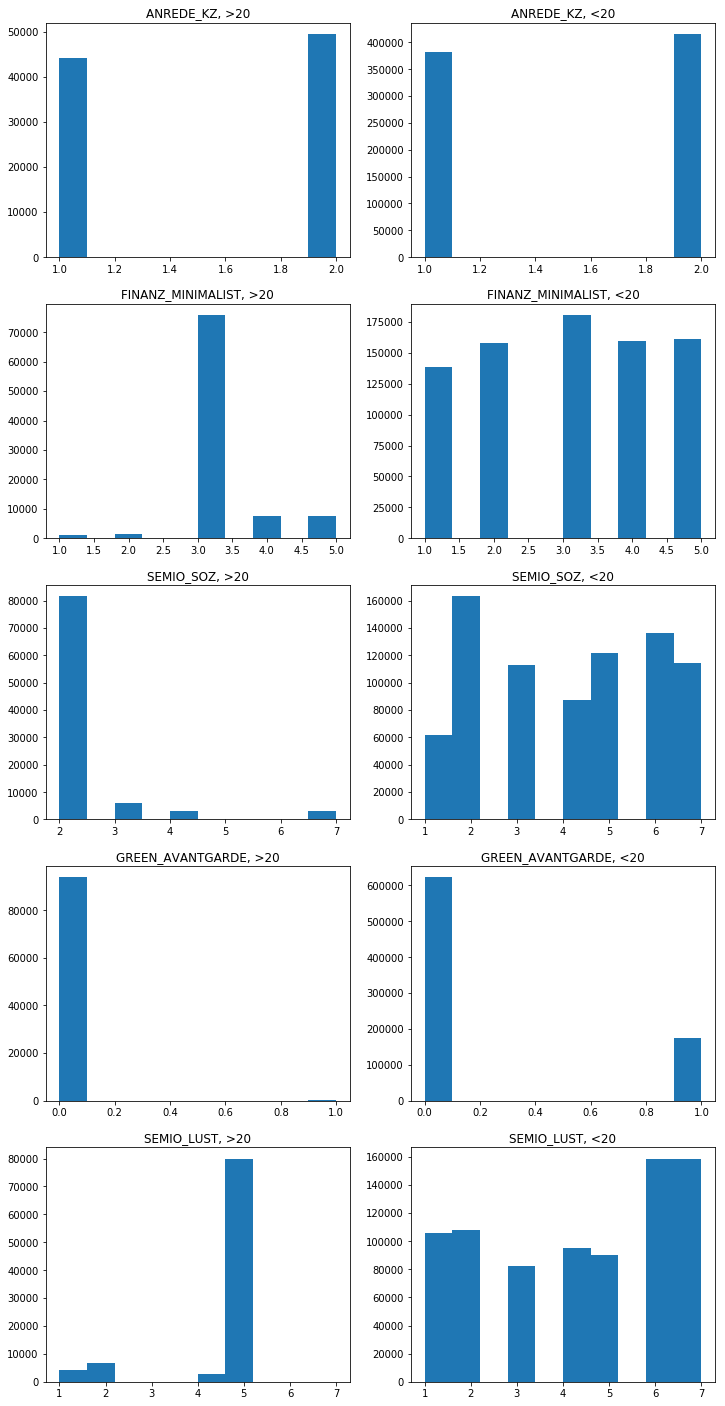

In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
plt.figure(figsize=[12,25])

plt.subplot2grid((5,2),(0,0))
plt.title('ANREDE_KZ, >20')
plt.hist(azdias_gt_20['ANREDE_KZ'])

plt.subplot2grid((5,2),(0,1))
plt.title('ANREDE_KZ, <20')
plt.hist(azdias_lt_20['ANREDE_KZ'])

plt.subplot2grid((5,2),(1,0))
plt.title('FINANZ_MINIMALIST, >20')
plt.hist(azdias_gt_20['FINANZ_MINIMALIST'])

plt.subplot2grid((5,2),(1,1))
plt.title('FINANZ_MINIMALIST, <20')
plt.hist(azdias_lt_20['FINANZ_MINIMALIST'])

plt.subplot2grid((5,2),(2,0))
plt.title('SEMIO_SOZ, >20')
plt.hist(azdias_gt_20['SEMIO_SOZ'])

plt.subplot2grid((5,2),(2,1))
plt.title('SEMIO_SOZ, <20')
plt.hist(azdias_lt_20['SEMIO_SOZ'])

plt.subplot2grid((5,2),(3,0))
plt.title('GREEN_AVANTGARDE, >20')
plt.hist(azdias_gt_20['GREEN_AVANTGARDE'])

plt.subplot2grid((5,2),(3,1))
plt.title('GREEN_AVANTGARDE, <20')
plt.hist(azdias_lt_20['GREEN_AVANTGARDE'])

plt.subplot2grid((5,2),(4,0))
plt.title('SEMIO_LUST, >20')
plt.hist(azdias_gt_20['SEMIO_LUST'])

plt.subplot2grid((5,2),(4,1))
plt.title('SEMIO_LUST, <20')
plt.hist(azdias_lt_20['SEMIO_LUST'])


plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row



I divide data rows into two subgroups in terms of whether or not the amount of missing values is greater than 20. Then I plot the distribution of 5 selected features where there are no missing value of these two subgroups. According to the distribution plots, the distribution of data with lots of missing values are qualitatively different from data with few or no missing values for most features other than ANREDE_KZ.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which I prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I will need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I will perform an investigation of the categorical and mixed-type features. Then, in the last part, I will create a new data frame with only the selected and engineered columns.

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


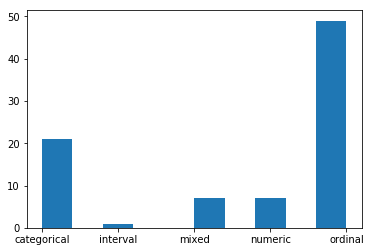

In [15]:
# How many features are there of each data type?
print(feat_info['type'].value_counts())
plt.hist(feat_info['type'])
plt.show()

# [type=='categorical']

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- There is one binary variable that takes on non-numeric values. For this one, I re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), I encode the values using multiple dummy variables

In [16]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_feats = []
for n, attri in enumerate(feat_info.loc[feat_info['type'] == 'categorical']['attribute']):
    if attri in feats_out:
        pass
    else:
        cat_feats.append(attri)
        print('----',n, attri,'----')
        print(azdias[attri].value_counts())

          
    

---- 1 ANREDE_KZ ----
2.0    465305
1.0    425916
Name: ANREDE_KZ, dtype: int64
---- 2 CJT_GESAMTTYP ----
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: CJT_GESAMTTYP, dtype: int64
---- 3 FINANZTYP ----
6.0    290367
1.0    199572
4.0    130625
2.0    110867
5.0    106436
3.0     53354
Name: FINANZTYP, dtype: int64
---- 4 GFK_URLAUBERTYP ----
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64
---- 5 GREEN_AVANTGARDE ----
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
---- 6 LP_FAMILIE_FEIN ----
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64
---- 7 LP_FAMILIE_GROB ----
1.0    426379
5.0    200780
2.0    104305
4.0    

In [17]:
print(cat_feats)

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [18]:
# Re-encode categorical variable(s) to be kept in the analysis.

# I moved the get_dummy part in the last
azdias['OST_WEST_KZ'].map({'W':0, 'O':1})

from sklearn.preprocessing import OneHotEncoder
print(len(list(azdias)))
one_hot_encoded_azdias = pd.get_dummies(azdias, columns = cat_feats)
one_hot_encoded_azdias_headers = list(one_hot_encoded_azdias)
print(len(list(one_hot_encoded_azdias)))
# list(one_hot_encoded_azdias)

79
201


In [19]:

mix_feat = []
for n, attri in enumerate(feat_info.loc[feat_info['type'] == 'mixed']['attribute']):
    if attri in feats_out:
        pass
    else:
        mix_feat.append(attri)
        print('----',n, attri,'----')
        print(azdias[attri].value_counts())
        
# azdias['CAMEO_INTL_2015'].map({'XX':np.nan})


---- 0 LP_LEBENSPHASE_FEIN ----
1.0     62667
5.0     55542
6.0     45614
2.0     39434
8.0     30475
11.0    26710
29.0    26577
7.0     26508
13.0    26085
10.0    25789
31.0    23987
12.0    23300
30.0    22361
15.0    20062
3.0     19985
19.0    19484
37.0    18525
4.0     17595
14.0    17529
20.0    17132
32.0    17105
39.0    16182
40.0    15150
27.0    14475
16.0    14466
38.0    13914
35.0    13679
34.0    13074
9.0     13066
21.0    12766
28.0    12264
24.0    12091
36.0    10505
25.0    10370
23.0     9191
22.0     7224
18.0     7168
33.0     6066
17.0     5888
26.0     3584
Name: LP_LEBENSPHASE_FEIN, dtype: int64
---- 1 LP_LEBENSPHASE_GROB ----
2.0     158139
1.0     139681
3.0     115624
12.0     74276
4.0      54443
5.0      49672
9.0      48938
10.0     41092
11.0     32819
8.0      30323
6.0      29181
7.0      22461
Name: LP_LEBENSPHASE_GROB, dtype: int64
---- 2 PRAEGENDE_JUGENDJAHRE ----
14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0   

#### Discussion 1.2.1: Re-Encode Categorical Features


Other than features that are have been dropped previously, there are in total 20 categorical features and 7 mixed features. I encoded categorical features by getting their dummy variables. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [20]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# new features:
# - DECADE: 40s: 1, 50s: 2, 60s: 3, 70s:4, 80s:5, 90:6
# - MOVEMENT: Avantgarde: 0, mainstream: 1

# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)


one_hot_encoded_azdias['MOVEMENT'] = one_hot_encoded_azdias['PRAEGENDE_JUGENDJAHRE'].map({1:1, 2:0, 3:0, 4:1, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0})

one_hot_encoded_azdias['DECADE'] = one_hot_encoded_azdias['PRAEGENDE_JUGENDJAHRE'].map({1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6})


In [21]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

one_hot_encoded_azdias.loc[one_hot_encoded_azdias['CAMEO_INTL_2015']=='XX'] = 0
one_hot_encoded_azdias.loc[one_hot_encoded_azdias['CAMEO_INTL_2015'].isnull()] = 0

one_hot_encoded_azdias['WEALTH'] = one_hot_encoded_azdias["CAMEO_INTL_2015"].astype(int)//10
one_hot_encoded_azdias['LIFE_STAGE'] = one_hot_encoded_azdias["CAMEO_INTL_2015"].astype(int)%10

one_hot_encoded_azdias.loc[one_hot_encoded_azdias['CAMEO_INTL_2015'] == 0] = np.nan
one_hot_encoded_azdias.loc[one_hot_encoded_azdias['WEALTH'] == 0] = np.nan
one_hot_encoded_azdias.loc[one_hot_encoded_azdias['LIFE_STAGE'] == 0] = np.nan

one_hot_encoded_azdias["WEALTH"].value_counts()

5.0    223582
2.0    190691
4.0    189960
1.0    119443
3.0     68193
Name: WEALTH, dtype: int64

In [ ]:
one_hot_encoded_azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'])
one_hot_encoded_azdias["WOHNLAGE"] = one_hot_encoded_azdias["WOHNLAGE"].apply(lambda x: np.nan if (x == 7)|(x == 8) else x)

#### Discussion 1.2.2: Engineer Mixed-Type Features

For the feature PRAEGENDE_JUGENDJAHRE, I created two new features 'MOVEMENT' and 'DECADE' to separate the combined feature. Similarly, for the feature 'CAMEO_INTL_2015', I created two new features 'WEALTH' and 'LIFE_STAGE'. As for other mixed features, 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB' have breakdown features such as 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN' which can describe them, so they can be dropped. Interms of the feature 'WOHNLAGE', it has different meanings between 7,8 and 1 to 5, so I fised it by mapping nan to 7 and 8.  

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [22]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [23]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
one_hot_encoded_azdias.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)

# one_hot_encoded_azdias.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)
# azdias.columns.tolist()

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [12]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for n, feat in enumerate(feat_info['attribute']):
        values = feat_info.loc[n, 'missing_or_unknown']
    values_list = []
    try:
        values_list = [int(x) for x in values[1:-1].split(',')]
        for value in values_list:
            customers.loc[customers[feat] == value, feat] = np.nan
            df.loc[df[feat]==value, feat] = np.nan
    except:
        pass
    feats_out = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    # remove selected columns and rows, ...
    df.drop(feats_out, axis = 1, inplace = True)
    print('step 1', len(list(df)))
    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'].map({'W':0, 'O':1})
    cat_feats = ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',\
                 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    one_hot_encoded_df = pd.get_dummies(df, columns = cat_feats)
    intermediate_headers = set(one_hot_encoded_df)
    print('step 2', len(list(one_hot_encoded_df)))
    one_hot_encoded_df['MOVEMENT'] = one_hot_encoded_df['PRAEGENDE_JUGENDJAHRE'].map({1:1, 2:0, 3:0, 4:1, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0})
    one_hot_encoded_df['DECADE'] = one_hot_encoded_df['PRAEGENDE_JUGENDJAHRE'].map({1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6})
    print('step 3', len(list(one_hot_encoded_df)))
    one_hot_encoded_df.loc[one_hot_encoded_df['CAMEO_INTL_2015']=='XX'] = 0
    one_hot_encoded_df.loc[one_hot_encoded_df['CAMEO_INTL_2015'].isnull()] = 0

    one_hot_encoded_df['WEALTH'] = one_hot_encoded_df["CAMEO_INTL_2015"].astype(int)//10
    one_hot_encoded_df['LIFE_STAGE'] = one_hot_encoded_df["CAMEO_INTL_2015"].astype(int)%10
    print('step 4', len(list(one_hot_encoded_df)))
    one_hot_encoded_df.loc[one_hot_encoded_df['CAMEO_INTL_2015'] == 0] = np.nan
    one_hot_encoded_df.loc[one_hot_encoded_df['WEALTH'] == 0] = np.nan
    one_hot_encoded_df.loc[one_hot_encoded_df['LIFE_STAGE'] == 0] = np.nan
    one_hot_encoded_df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis = 1, inplace=True)
    one_hot_encoded_df["WOHNLAGE"] = one_hot_encoded_df["WOHNLAGE"].apply(lambda x: np.nan if (x == 7)|(x == 8) else x)
    one_hot_encoded_df.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace=True)
    print('step 5', len(list(one_hot_encoded_df)))
    # Return the cleaned dataframe.
    return one_hot_encoded_df, intermediate_headers
    
    

In [13]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')
one_hot_encoded_azdias, azdias_headers = clean_data(azdias)
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')
one_hot_encoded_customers, customers_headers = clean_data(customers)
feat_difference = list(azdias_headers-customers_headers)
headers = list(one_hot_encoded_customers)

step 1 79
step 2 206
step 3 208
step 4 210
step 5 206
step 1 79
step 2 205
step 3 207
step 4 209
step 5 205


In [14]:
try:
    one_hot_encoded_azdias.drop(feat_difference, axis = 1, inplace=True)
except:
    pass
try:
    one_hot_encoded_customers.drop(feat_difference, axis = 1, inplace=True)
except:
    pass

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before I apply dimensionality reduction techniques to the data, I perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features.

In [15]:
one_hot_encoded_azdias.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
count,791869.000000,791869.000000,791869.000000,791869.000000,791869.000000,791869.000000,791869.000000,791869.000000,787148.000000,791869.000000,...,791869.000000,791869.000000,791869.000000,791869.000000,791869.000000,791869.0,763597.000000,763597.000000,791869.000000,791869.000000
mean,2.817236,3.055574,2.716632,3.434459,2.839999,2.656688,3.119335,2.052327,3.443258,4.142136,...,0.025941,0.034950,0.031554,0.036108,0.008056,0.0,0.728611,4.331276,3.262098,2.873033
std,1.080889,1.377276,1.485532,1.376583,1.472807,1.399097,1.407146,0.996798,1.455106,1.940935,...,0.158960,0.183654,0.174811,0.186560,0.089391,0.0,0.444677,1.458114,1.464494,1.484771
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.000000,2.000000,1.000000
50%,3.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,2.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,4.000000,4.000000,3.000000
75%,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,3.000000,5.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,6.000000,5.000000,4.000000
max,9.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,6.000000,5.000000,5.000000


In [36]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
row_null_v2 = azdias.isnull().sum(axis = 1)

rows_full = []
rows_miss = []
for ind, value in enumerate(row_null_v2):
    if value >0:
        rows_miss.append(ind)
    else:
        rows_full.append(ind)
one_hot_encoded_azdias_full = one_hot_encoded_azdias.copy()
one_hot_encoded_azdias_full.drop(rows_miss, axis = 0, inplace = True)
one_hot_encoded_azdias_miss = one_hot_encoded_azdias.copy()
one_hot_encoded_azdias_miss.drop(rows_full, axis = 0, inplace = True)
headers = list(one_hot_encoded_azdias_full)
one_hot_encoded_azdias_full.describe()
azdias_miss_count = len(rows_miss)

In [17]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import MinMaxScaler
one_hot_encoded_azdias_full = pd.DataFrame(one_hot_encoded_azdias_full)
one_hot_encoded_azdias_full.describe()
# one_hot_encoded_azdias_full_mm = MinMaxScaler().fit_transform(one_hot_encoded_azdias_full)
# one_hot_encoded_azdias_full_mm.head(5)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
count,697537.000000,697537.000000,697537.000000,697537.000000,697537.000000,697537.000000,697537.000000,697537.000000,697537.000000,697537.000000,...,697537.000000,697537.000000,697537.000000,697537.000000,697537.000000,697537.0,674255.000000,674255.000000,697537.000000,697537.000000
mean,2.816995,3.019113,2.721785,3.438932,2.838338,2.603344,3.199092,2.064534,3.443542,4.186245,...,0.027372,0.036334,0.032920,0.037427,0.006896,0.0,0.728224,4.321617,3.302741,2.866205
std,1.080087,1.376511,1.492270,1.377404,1.474409,1.388524,1.378743,1.001372,1.456884,1.943538,...,0.163165,0.187119,0.178428,0.189807,0.082754,0.0,0.444875,1.451375,1.466517,1.496301
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.000000,2.000000,1.000000
50%,3.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,2.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,4.000000,4.000000,3.000000
75%,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,3.000000,5.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,6.000000,5.000000,4.000000
max,9.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,6.000000,5.000000,5.000000


In [18]:
from sklearn.preprocessing import Imputer, StandardScaler
imp = Imputer(missing_values=np.nan, strategy='mean')
one_hot_encoded_azdias_full = imp.fit_transform(one_hot_encoded_azdias_full)   
scaler = MinMaxScaler()
scaler.fit(one_hot_encoded_azdias_full)
one_hot_encoded_azdias_full_mm = scaler.transform(one_hot_encoded_azdias_full)


### Step 2.2: Perform Dimensionality Reduction

I am now ready to apply dimensionality reduction techniques with PCA. 

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data.
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Based on it, I select a value for the number of transformed features that I will retain for the clustering part of the project.
- Once I've made a choice for the number of components to keep, I re-fit a PCA instance to perform the decided-on transformation.

In [19]:
# Apply PCA to the data.

one_hot_encoded_azdias_full_mm = pd.DataFrame(one_hot_encoded_azdias_full_mm)

from sklearn.decomposition import PCA

pca = PCA()
azdias_pca = pca.fit_transform(one_hot_encoded_azdias_full_mm)




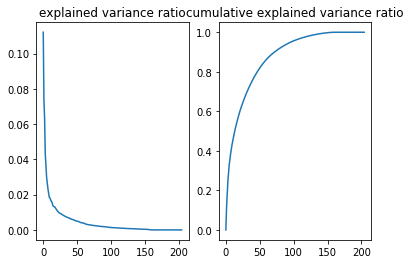

In [20]:
# Investigate the variance accounted for by each principal component.
cumulative = [sum(pca.explained_variance_ratio_[0:i]) for i in range(len(pca.explained_variance_ratio_))]

plt.subplot(121)
plt.title('explained variance ratio')
plt.plot(pca.explained_variance_ratio_)

plt.subplot(122)
plt.title('cumulative explained variance ratio')
plt.plot(cumulative)

plt.show()

In [21]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(25)
pca.fit(one_hot_encoded_azdias_full_mm)
azdias_pca = pca.transform(one_hot_encoded_azdias_full_mm)

### Discussion 2.2: Perform Dimensionality Reduction


According to the plot of cumulative explained variance, I selected 25 components as the explained variance when n_components = 25 is at the 'elbow' of the curve.  




### Step 2.3: Interpret Principal Components

Here I check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

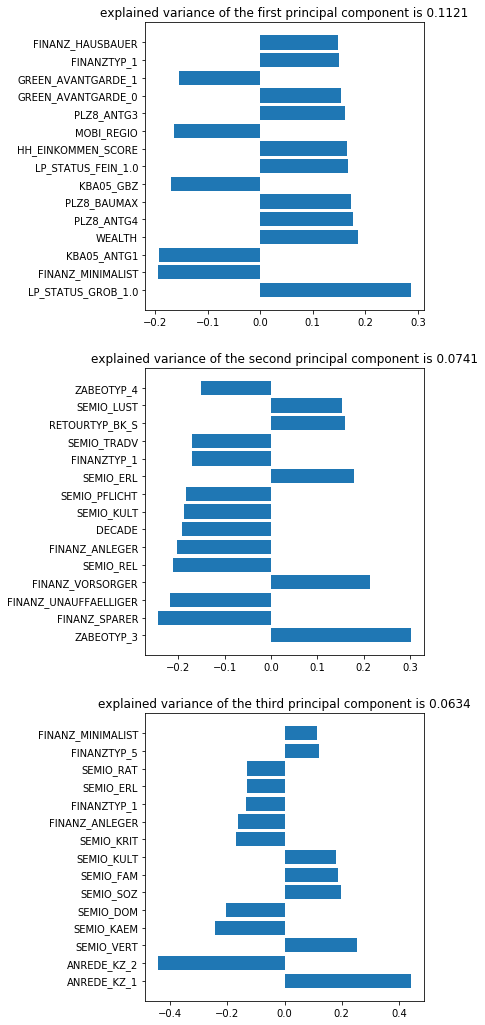

In [22]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def sorted_ith_components(i, pca):
    weight_first_components = np.array(pca.components_[i])
    sorted_weight_first_components_index = np.argsort(np.absolute(weight_first_components))[::-1]
    sorted_weight_first_components = [weight_first_components[sorted_weight_first_components_index[i]] for i in range(len(sorted_weight_first_components_index))]
    sorted_feature_names = [headers[sorted_weight_first_components_index[i]] for i in range(len(sorted_weight_first_components_index))]
    return sorted_feature_names, sorted_weight_first_components

def plot_first_three_components(pca):
    sorted_feature_names_three = []
    sorted_weight_first_components_three = []
    for i in range(3):
        sorted_feature_names, sorted_weight_first_components = sorted_ith_components(i, pca)
        sorted_feature_names_three.append(sorted_feature_names)
        sorted_weight_first_components_three.append(sorted_weight_first_components)
        
    plt.figure(figsize=(5,18))
    plt.subplot(311)
#     plt.barh(sorted_feature_names_three[0][0:10], sorted_weight_first_components_three[0][0:10])
    plt.barh(range(15), sorted_weight_first_components_three[0][0:15])    
    plt.yticks(range(15), sorted_feature_names_three[0][0:15])
    plt.title('explained variance of the first principal component is %.4f' %(pca.explained_variance_ratio_[0]))
    
    plt.subplot(312)
    plt.barh(range(15), sorted_weight_first_components_three[1][0:15])    
    plt.yticks(range(15), sorted_feature_names_three[1][0:15])
    plt.title('explained variance of the second principal component is %.4f' %(pca.explained_variance_ratio_[1]))
    
    plt.subplot(313)
    plt.barh(range(15), sorted_weight_first_components_three[2][0:15])    
    plt.yticks(range(15), sorted_feature_names_three[2][0:15])
    plt.title('explained variance of the third principal component is %.4f' %(pca.explained_variance_ratio_[2]))
    plt.show()
    
plot_first_three_components(pca)    

# print(sorted_feature_names[0:10], sorted_weight_first_components[0:10])

In [23]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

sorted_feature_names, sorted_weight_first_components = sorted_ith_components(1, pca)
print('sorted_feature_names:', sorted_feature_names[:10], '\n', 'sorted_weight_first_components', sorted_weight_first_components[:10])

sorted_feature_names: ['ZABEOTYP_3', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'SEMIO_REL', 'FINANZ_ANLEGER', 'DECADE', 'SEMIO_KULT', 'SEMIO_PFLICHT', 'SEMIO_ERL'] 
 sorted_weight_first_components [0.30257792578782189, -0.24384401191522675, -0.21726751877354705, 0.21329927762078871, -0.21113461625642613, -0.20171675527525199, -0.19219005053132515, -0.18655534348014954, -0.18334255963432811, 0.17814580750083245]


In [24]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

sorted_feature_names, sorted_weight_first_components = sorted_ith_components(2, pca)
print('sorted_feature_names:', sorted_feature_names[:10], '\n', 'sorted_weight_first_components', sorted_weight_first_components[:10])

sorted_feature_names: ['ANREDE_KZ_1', 'ANREDE_KZ_2', 'SEMIO_VERT', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_KULT', 'SEMIO_KRIT', 'FINANZ_ANLEGER'] 
 sorted_weight_first_components [0.44426199785976234, -0.44426199785976234, 0.25346529314036942, -0.24260355448819093, -0.20643584164233431, 0.19891217615972959, 0.18724373594401378, 0.18147662137337206, -0.16963557577431296, -0.1644810964073615]


### Discussion 2.3: Interpret Principal Components

Principal Components 1:
The strongest absolute feature weights: LP_STATUS_GROB_1.0 and WEALTH which implies that they have the greatest impact explaining the variation on PC1. 

Similarly, ZABEOTYP_3, ANREDE_KZ have the impact on the explained variation on PC2 and PC3, respectively. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

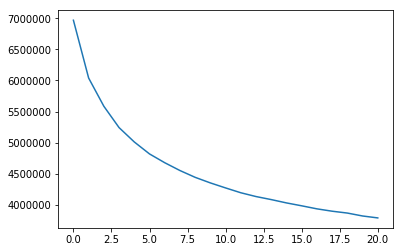

In [25]:
k = list(range(0,21))
scores = []
models = []
for i in k:
    kmeans = KMeans(i)
    model = kmeans.fit(azdias_pca)
    score = abs(kmeans.score(azdias_pca))
    scores.append(score)
    models.append(model)

# scores = [6970508.09917, 6039263.08526, 5584604.61783, 5240587.33568, 5009452.70083, 4816659.29444, 4675099.55078, 4549187.328, 4439525.45222, 4349567.92918\
#           , 4268751.51026, 4191062.8076, 4129920.87511, 4080906.87256, 4027378.6173, 3980746.63541, 3931914.1479, 3893834.40145, 3863981.93063, 3816863.05408, 3785728.78659]

plt.plot(k, scores)
plt.show()

In [26]:
kmeans = KMeans(7)
model=kmeans.fit(azdias_pca)

In [27]:
azdias_pred = model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

According to the plot of score against the number of clusterings n, I decided to use n= 7 as it is the elbow value.

### Step 3.2: Apply All Steps to the Customer Data

In [28]:
# Load in the customer demographics data.
customers=pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter = ';')

In [43]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.


def get_full_rows(df):
    row_null_v2 = df.isnull().sum(axis = 1)
    rows_full = []
    rows_miss = []
    for ind, value in enumerate(row_null_v2):
        if value >0:
            rows_miss.append(ind)
        else:
            rows_full.append(ind)
    df_full = df.copy()
    df.drop(rows_miss, axis = 0, inplace = True)
    return df_full, rows_miss

# data cleaning of the customers
# one_hot_encoded_customers, customers_headers = clean_data(customers)


print(len(list(one_hot_encoded_customers)))
one_hot_encoded_customers_full, rows_customers_miss = get_full_rows(one_hot_encoded_customers)
one_hot_encoded_customers_full = pd.DataFrame(one_hot_encoded_customers_full)
# feature scaling of the customers

one_hot_encoded_customers_full = imp.transform(one_hot_encoded_customers_full)   
one_hot_encoded_customers_full_mm = scaler.transform(one_hot_encoded_customers_full)
one_hot_encoded_customers_full_mm = pd.DataFrame(one_hot_encoded_customers_full_mm)
# Dimensionality reduction of the customers, PCA n_components = 25
customers_pca = pca.transform(one_hot_encoded_customers_full_mm)
# predict the clustering of the customers
customers_pred = model.predict(customers_pca)

205


### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. Here I will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.



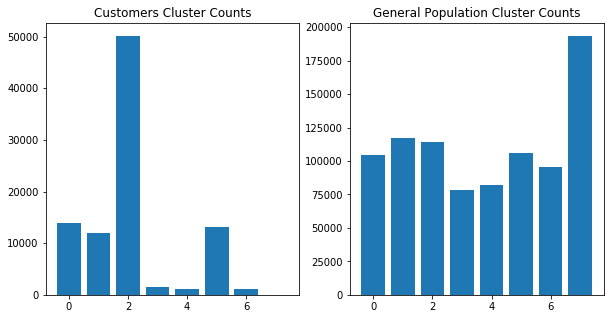

In [51]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
import seaborn as sns

customers_pred = pd.DataFrame(customers_pred)
azdias_pred = pd.DataFrame(azdias_pred)

azdias_cluster_value = list(range(8))
azdias_cluster_count = []
for i in range(7):
    azdias_cluster_count.append(azdias_pred[0].value_counts()[i])
azdias_cluster_count.append(azdias_miss_count)

customer_cluster_value = list(range(8))
customer_cluster_count = []
for i in range(7):
    customer_cluster_count.append(customers_pred[0].value_counts()[i])
customer_cluster_count.append(len(rows_customers_miss))

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('Customers Cluster Counts')
plt.bar(customer_cluster_value, customer_cluster_count)
# plt.bar(customers_pred[0].value_counts()[0], customers_pred[0].value_counts()[1])
# sns.countplot(x = 0, data = customers_pred)

plt.subplot(122)
plt.title('General Population Cluster Counts')
plt.bar(azdias_cluster_value, azdias_cluster_count)
# sns.countplot(x = 0, data = azdias_pred)
plt.show()

In [52]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

before_pca_over = pca.inverse_transform(model.cluster_centers_[2])
before_scaling_over = scaler.inverse_transform(before_pca_over.reshape(1,205))
print('centroid of the cluster 1')
for i in range(len(before_pca_over)):
    print(list(headers)[i], before_scaling_over[0,i])


centroid of the cluster 1
ALTERSKATEGORIE_GROB 3.14133293553
FINANZ_MINIMALIST 4.37562060477
FINANZ_SPARER 1.96031961499
FINANZ_VORSORGER 3.90946943944
FINANZ_ANLEGER 2.07326598427
FINANZ_UNAUFFAELLIGER 2.42896505778
FINANZ_HAUSBAUER 2.05224973359
HEALTH_TYP 2.07486657368
RETOURTYP_BK_S 3.51743431812
SEMIO_SOZ 4.31414989046
SEMIO_FAM 3.79414760066
SEMIO_REL 3.39957855878
SEMIO_MAT 3.38675190407
SEMIO_VERT 4.82238417881
SEMIO_LUST 4.9984200449
SEMIO_ERL 4.82111201203
SEMIO_KULT 3.89880236926
SEMIO_RAT 3.33968048256
SEMIO_KRIT 4.18346658191
SEMIO_DOM 4.54487116575
SEMIO_KAEM 4.01670100669
SEMIO_PFLICHT 3.52206454756
SEMIO_TRADV 3.33512447051
ANZ_PERSONEN 2.38697264256
ANZ_TITEL 0.0103215202661
HH_EINKOMMEN_SCORE 2.3898528425
W_KEIT_KIND_HH 3.81517192407
WOHNDAUER_2008 8.46956177354
ANZ_HAUSHALTE_AKTIV 1.5934299109
ANZ_HH_TITEL 0.020494390796
KONSUMNAEHE 3.4470869116
MIN_GEBAEUDEJAHR 1992.74683786
WOHNLAGE 2.66139711278
KBA05_ANTG1 2.84752163831
KBA05_ANTG2 1.07586527781
KBA05_ANTG3 0.031

In [53]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

before_pca_under = pca.inverse_transform(model.cluster_centers_[6])
before_scaling_under = scaler.inverse_transform(before_pca_under.reshape(1,205))
print('centroid of the cluster 1')
for i in range(len(before_pca_under)):
    print(list(headers)[i], before_scaling_under[0,i])

centroid of the cluster 1
ALTERSKATEGORIE_GROB 1.93811948622
FINANZ_MINIMALIST 1.11322183196
FINANZ_SPARER 4.45050904557
FINANZ_VORSORGER 2.23265563959
FINANZ_ANLEGER 4.36794256894
FINANZ_UNAUFFAELLIGER 3.83084184348
FINANZ_HAUSBAUER 4.30014431116
HEALTH_TYP 1.61065637025
RETOURTYP_BK_S 2.69295924641
SEMIO_SOZ 3.24797479453
SEMIO_FAM 3.92298926473
SEMIO_REL 5.32386712331
SEMIO_MAT 4.47806839177
SEMIO_VERT 2.28987837794
SEMIO_LUST 3.34429186544
SEMIO_ERL 4.43183715569
SEMIO_KULT 4.00195523517
SEMIO_RAT 5.75664009904
SEMIO_KRIT 5.39987133658
SEMIO_DOM 5.92504396341
SEMIO_KAEM 5.9954184609
SEMIO_PFLICHT 5.98019993881
SEMIO_TRADV 5.05976674546
ANZ_PERSONEN 1.53263780834
ANZ_TITEL 0.00254264948789
HH_EINKOMMEN_SCORE 5.50144437603
W_KEIT_KIND_HH 3.55994453503
WOHNDAUER_2008 7.26101878726
ANZ_HAUSHALTE_AKTIV 14.2792238482
ANZ_HH_TITEL 0.0569177462783
KONSUMNAEHE 2.20620073708
MIN_GEBAEUDEJAHR 1992.44638644
WOHNLAGE 3.38702749208
KBA05_ANTG1 0.545778935771
KBA05_ANTG2 1.33067627813
KBA05_ANTG3

### Discussion 3.3: Compare Customer Data to Demographics Data



Cluster 2 is overrepresent in the customers segment. According to the data dictionary.md, customers are more densed in 46-60 years old, conservative financing and low returner, average earner families, low education level, etc. On the contrary, customers are less represented in the group who are <45 years old, relatively high income, 708 years length of residence, etc. It is noted that here I add a new cluster 7 for data with missed value, and this group is underrepresented in customers, probably because customers are better documented. 